#### White Noise
Time series where data doesn't follow a pattern.<br>
- Unpredictable
- Conditions:
  - Constant mean $\mu$
  - Constant variant $\sigma ^2$
  - No autocorrelation 

***Autocorrelation***: How correlated a series is with past versions of itself 
$$ \rho = corr(x_t, x_{t-q})$$
No autocorrelation = no clear relation between past and present valueas of a time series.

***White Noise***: A sequence of random data, where every value has a time period assosiated with it. Note that adding noise to a model can improve it's predictions.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_theme(rc={"font.size": 23, "axes.titlesize": 23, "axes.labelsize": 22,
                  'xtick.labelsize': 15, 'ytick.labelsize': 15,})

### Loading and Transforming data

In [3]:
# Loading
directory = "C:/Users/42111/Desktop/DataScience/analysis/archive/dataScience365/3_1_index2018/Index2018.csv"
raw_data = pd.read_csv(directory).copy()

# Transforming to datetime as index with b freq
raw_data['date'] = pd.to_datetime(raw_data['date'], dayfirst=True)
raw_data.set_index('date', inplace=True)
raw_data = raw_data.asfreq('b')

# Fill na's with last valid observation before the nan
raw_data = raw_data.fillna(method='ffill')

# Keep just dax stock market
dax_df = raw_data['dax'].to_frame()
dax_df.head()

,dax
date,
1994-01-07,2224.95
1994-01-10,2225.00
1994-01-11,2228.10
1994-01-12,2182.06
1994-01-13,2142.37


#### Creating a training and testing data sets

In [13]:
size = int(len(dax_df) * 0.8) # To separate 80% of the data
df_train, df_test = dax_df.iloc[:size].copy(), dax_df.iloc[size:].copy()
df_train.head()

,dax
date,
1994-01-07,2224.95
1994-01-10,2225.00
1994-01-11,2228.10
1994-01-12,2182.06
1994-01-13,2142.37


## Generate Noise White Noise
---

First we generate an array of random values from a normal distribution.
$$ X \sim N(\mu, \sigma ^ 2) $$
Which is read as *X behaves according to a normal distribution*

In this case we need to make it comparable to the dax stock values. So we need
$$ X \sim N \left( \mu_{dax}, \sigma_{dax} ^2 \right)$$

In [11]:
wn = np.random.normal(loc=df_train['dax'].mean(),
                      scale=df_train['dax'].std(),
                      size=len(df_train))

In [14]:
df_train['wn'] = wn

In [15]:
df_train.describe()

,dax,wn
count,5021.000000,5021.000000
mean,4984.132354,4995.621762
std,1714.802821,1716.187861
min,1911.700000,-675.185693
25%,3733.930000,3800.518901
50%,5123.500000,4972.913257
75%,6346.190000,6171.027137
max,8105.690000,11361.713803


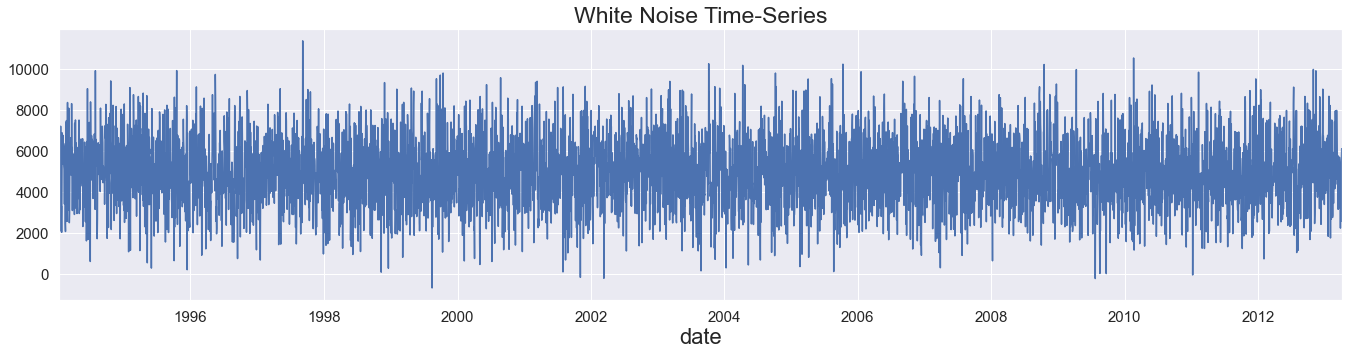

In [31]:
df_train['wn'].plot(figsize=(23,5), title='White Noise Time-Series');

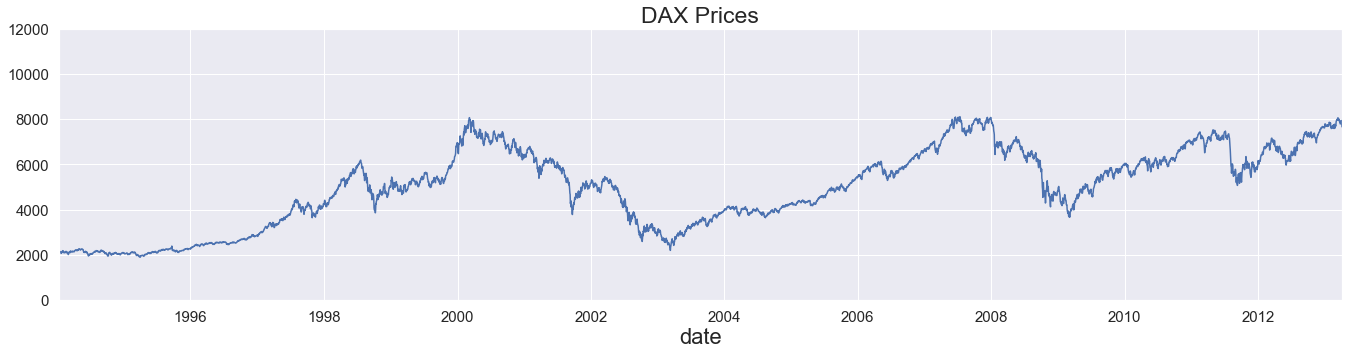

In [35]:
df_train['dax'].plot(figsize=(23, 5), title='DAX Prices', ylim=(0, 12_000));